In [1]:
import sys, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

proj_root = pathlib.Path("..").resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))


In [2]:
from src.dataset import build_dataset
from src.modeling import train_test_split_time
from src.config import TARGET_COL, FEATURE_COLS

df_feat = build_dataset(include_vix=True).sort_values("date").reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split_time(df_feat, test_size=0.2)

print("df_feat shape:", df_feat.shape)
print("Période:", df_feat["date"].min().date(), "→", df_feat["date"].max().date())
print("Train size:", len(X_train), "| Test size:", len(X_test))
print("Target balance:", df_feat[TARGET_COL].value_counts(normalize=True).round(3))

df_feat[["date", "close"] + [c for c in FEATURE_COLS if c in df_feat.columns]].tail(5)


df_feat shape: (9267, 22)
Période: 1990-01-03 → 2025-10-23
Train size: 7413 | Test size: 1854
Target balance: y_up
1    0.502
0    0.498
Name: proportion, dtype: float64


,date,close,ret_lag1,ret_lag2,ret_lag3,ret_lag5,ret_rollmean_5,ret_rollstd_5,ret_rollstd_10,ret_rollstd_20,abs_ret_lag1,range_pct,vix_lag1
9262,2025-10-17,1.16708,0.003822,0.003084,0.003128,0.004107,0.001001,0.003299,0.003726,0.003673,0.003822,0.006084,25.31
9263,2025-10-20,1.16449,-0.001514,0.003822,0.003084,-0.003513,0.001260,0.002880,0.003700,0.003519,0.001514,0.003143,20.78
9264,2025-10-21,1.16050,-0.002219,-0.001514,0.003822,0.003128,-0.000051,0.003281,0.003593,0.003541,0.002219,0.004929,18.23
9265,2025-10-22,1.16128,-0.003426,-0.002219,-0.001514,0.003084,-0.000533,0.002855,0.003535,0.003312,0.003426,0.003875,17.87
9266,2025-10-23,1.15958,0.000672,-0.003426,-0.002219,0.003822,-0.001590,0.001492,0.003054,0.002995,0.000672,0.002052,18.60


In [3]:
import xgboost as xgb

In [4]:
from src.evaluation import evaluate_classifier

# Pourquoi XGBoost:
# - très bon modèle tabulaire (arbres boostés)
# - capture des non-linéarités (utile en finance)
# - reste "classique ML", pas deep learning

xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=0,
)

xgb_model.fit(X_train, y_train)
evaluate_classifier(xgb_model, X_train, y_train, X_test, y_test, name="XGBoost (advanced)")


=== XGBoost (advanced) ===
Accuracy: 0.504
ROC-AUC : 0.506
Confusion matrix:
 [[425 498]
 [421 510]]

Classification report:
               precision    recall  f1-score   support

           0      0.502     0.460     0.480       923
           1      0.506     0.548     0.526       931

    accuracy                          0.504      1854
   macro avg      0.504     0.504     0.503      1854
weighted avg      0.504     0.504     0.503      1854



(0.5043149946062567, 0.505595167302252)

In [5]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss

# calibration "sigmoid" = Platt scaling (simple, marche souvent)
xgb_cal = CalibratedClassifierCV(xgb_model, method="sigmoid", cv=3)
xgb_cal.fit(X_train, y_train)

proba_uncal = xgb_model.predict_proba(X_test)[:, 1]
proba_cal = xgb_cal.predict_proba(X_test)[:, 1]

print("Brier XGB uncal:", round(brier_score_loss(y_test, proba_uncal), 4))
print("Brier XGB cal  :", round(brier_score_loss(y_test, proba_cal), 4))


Brier XGB uncal: 0.256
Brier XGB cal  : 0.2503


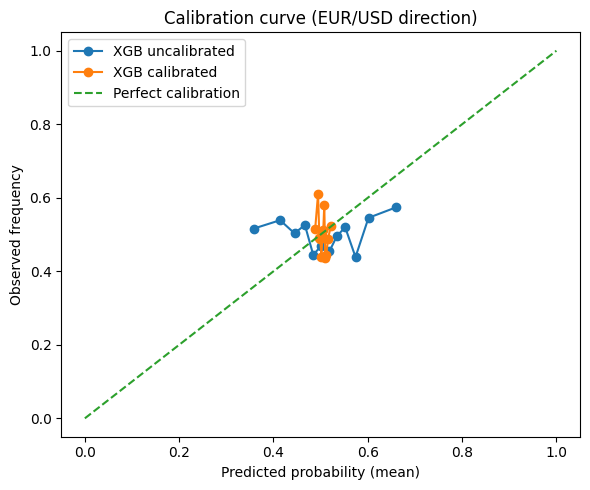

In [6]:
frac_uncal, mean_uncal = calibration_curve(y_test, proba_uncal, n_bins=12, strategy="quantile")
frac_cal, mean_cal = calibration_curve(y_test, proba_cal, n_bins=12, strategy="quantile")

plt.figure(figsize=(6, 5))
plt.plot(mean_uncal, frac_uncal, marker="o", label="XGB uncalibrated")
plt.plot(mean_cal, frac_cal, marker="o", label="XGB calibrated")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.title("Calibration curve (EUR/USD direction)")
plt.xlabel("Predicted probability (mean)")
plt.ylabel("Observed frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
from src.modeling import build_logreg_pipeline, build_random_forest, build_gradient_boosting

# Modèles "cours" + hyperparams déjà un peu réglés dans modeling.py
lr = build_logreg_pipeline()
rf = build_random_forest()
gb = build_gradient_boosting()

for m in [lr, rf, gb]:
    m.fit(X_train, y_train)

evaluate_classifier(lr, X_train, y_train, X_test, y_test, name="LogReg (advanced config)")
evaluate_classifier(rf, X_train, y_train, X_test, y_test, name="RandomForest (advanced config)")
evaluate_classifier(gb, X_train, y_train, X_test, y_test, name="GradientBoosting (advanced config)")


=== LogReg (advanced config) ===
Accuracy: 0.504
ROC-AUC : 0.496
Confusion matrix:
 [[334 589]
 [331 600]]

Classification report:
               precision    recall  f1-score   support

           0      0.502     0.362     0.421       923
           1      0.505     0.644     0.566       931

    accuracy                          0.504      1854
   macro avg      0.503     0.503     0.493      1854
weighted avg      0.503     0.504     0.494      1854

=== RandomForest (advanced config) ===
Accuracy: 0.497
ROC-AUC : 0.499
Confusion matrix:
 [[313 610]
 [322 609]]

Classification report:
               precision    recall  f1-score   support

           0      0.493     0.339     0.402       923
           1      0.500     0.654     0.567       931

    accuracy                          0.497      1854
   macro avg      0.496     0.497     0.484      1854
weighted avg      0.496     0.497     0.485      1854

=== GradientBoosting (advanced config) ===
Accuracy: 0.511
ROC-AUC : 0.52
Co

(0.511326860841424, 0.5198978719046494)

In [19]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.metrics import accuracy_score, roc_auc_score

# Stacking manuel : on crée des probas OOF sur le train, puis une logreg combine tout ça

base_models = {
    "lr": build_logreg_pipeline(),
    "rf": build_random_forest(),
    "gb": build_gradient_boosting(),
    "xgb": xgb.XGBClassifier(
        n_estimators=400, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        objective="binary:logistic", eval_metric="logloss",
        random_state=0,
    ),
}

tscv = TimeSeriesSplit(n_splits=5)
oof = np.full((len(X_train), len(base_models)), np.nan)

# 1) OOF probas sur TRAIN (walk-forward)
for tr_idx, va_idx in tscv.split(X_train):
    for j, model in enumerate(base_models.values()):
        m = clone(model)
        m.fit(X_train[tr_idx], y_train[tr_idx])
        oof[va_idx, j] = m.predict_proba(X_train[va_idx])[:, 1]

mask = ~np.isnan(oof).any(axis=1)
X_meta_train, y_meta_train = oof[mask], y_train[mask]

# 2) Meta-modèle = logreg sur les probas
meta = LogisticRegression(max_iter=1000)
meta.fit(X_meta_train, y_meta_train)

# 3) Refit des modèles de base sur tout le train
fitted_base = {name: clone(m).fit(X_train, y_train) for name, m in base_models.items()}

# 4) Proba stacking (fonction utile pour la suite)
def stack_manual_predict_proba(X):
    base_probas = np.column_stack([m.predict_proba(X)[:, 1] for m in fitted_base.values()])
    return meta.predict_proba(base_probas)[:, 1]

# 5) Eval rapide sur TEST
proba_stack = stack_manual_predict_proba(X_test)
pred_stack = (proba_stack >= 0.5).astype(int)

print("=== Manual stacking ===")
print("Accuracy:", round(accuracy_score(y_test, pred_stack), 3))
print("ROC-AUC :", round(roc_auc_score(y_test, proba_stack), 3))


=== Manual stacking ===
Accuracy: 0.496
ROC-AUC : 0.489


In [20]:
from sklearn.ensemble import VotingClassifier

# Voting "soft" = moyenne des proba (mais pas d'apprentissage des poids)
voting = VotingClassifier(
    estimators=[
        ("lr", build_logreg_pipeline()),
        ("rf", build_random_forest()),
        ("gb", build_gradient_boosting()),
        ("xgb", xgb_model),
    ],
    voting="soft",
)

voting.fit(X_train, y_train)
evaluate_classifier(voting, X_train, y_train, X_test, y_test, name="Voting ensemble (soft)")


=== Voting ensemble (soft) ===
Accuracy: 0.497
ROC-AUC : 0.508
Confusion matrix:
 [[378 545]
 [388 543]]

Classification report:
               precision    recall  f1-score   support

           0      0.493     0.410     0.448       923
           1      0.499     0.583     0.538       931

    accuracy                          0.497      1854
   macro avg      0.496     0.496     0.493      1854
weighted avg      0.496     0.497     0.493      1854



(0.4967637540453074, 0.5081000752927047)

In [21]:
from sklearn.metrics import f1_score

# Ici on utilise les probas OOF du meta-modèle (pas de fuite)
# X_meta_train = probas des modèles de base (OOF)
# meta = le meta-modèle déjà fit

proba_meta_oof = meta.predict_proba(X_meta_train)[:, 1]

def best_threshold_by_f1_from_proba(y_true, proba):
    thresholds = np.linspace(0.40, 0.60, 81)  # zone réaliste
    best_t, best_f1 = 0.5, -1
    for t in thresholds:
        pred = (proba >= t).astype(int)
        score = f1_score(y_true, pred)
        if score > best_f1:
            best_f1 = score
            best_t = t
    return float(best_t), float(best_f1)

best_t, best_f1 = best_threshold_by_f1_from_proba(y_meta_train, proba_meta_oof)
print("Best threshold (OOF train):", round(best_t, 3), "| OOF Train F1:", round(best_f1, 3))


Best threshold (OOF train): 0.4 | OOF Train F1: 0.668


In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# proba_stack vient de la cellule "Manual Stacking"
pred_test = (proba_stack >= best_t).astype(int)

print("=== Manual Stacking (threshold tuned on OOF train) ===")
print("Threshold:", round(best_t, 3))
print("Accuracy:", round(accuracy_score(y_test, pred_test), 3))
print("ROC-AUC :", round(roc_auc_score(y_test, proba_stack), 3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test))
print("\nReport:\n", classification_report(y_test, pred_test, digits=3))


=== Manual Stacking (threshold tuned on OOF train) ===
Threshold: 0.4
Accuracy: 0.502
ROC-AUC : 0.489
Confusion matrix:
 [[  0 923]
 [  0 931]]

Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000       923
           1      0.502     1.000     0.669       931

    accuracy                          0.502      1854
   macro avg      0.251     0.500     0.334      1854
weighted avg      0.252     0.502     0.336      1854



c:\Users\simon\OneDrive\Bureau\Projet Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\simon\OneDrive\Bureau\Projet Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\simon\OneDrive\Bureau\Projet Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

In [23]:
from src.inference import predict_date_ensemble

# Modèles déjà fit plus haut (lr/rf/gb + xgb_model)
models_dict = {
    "LogReg": lr,
    "RandomForest": rf,
    "GradientBoosting": gb,
    "XGBoost": xgb_model,
}

# 1) moyenne des probas (comme ton inference.py)
res = predict_date_ensemble(
    df_feat=df_feat,
    models=models_dict,
    date=None,          # None = random dans zone test
    test_size=0.2,
    random_state=42
)

# 2) stacking manuel (proba calculée via stack_manual_predict_proba)
# on récupère les features de la même date
row = df_feat[df_feat["date"] == res["date"]].iloc[0]
X_row = row[[c for c in FEATURE_COLS if c in row.index]].values.reshape(1, -1)
p_stack = float(stack_manual_predict_proba(X_row)[0])

print("=== Single-date prediction (random TEST date) ===")
print("Date:", res["date"])
print("EUR/USD close:", float(row["close"]))
print("VIX:", float(row["vix"]) if ("vix" in row.index and pd.notna(row["vix"])) else "NA")

print("\n--- Avg(models) ---")
print("Probabilités UP par modèle:", res["model_probas_up"])
print("Moyenne P(UP):", round(res["avg_proba_up"], 3))
print("Prédiction J+1:", res["predicted_direction"])

print("\n--- Manual stacking ---")
print("P(UP) stacking:", round(p_stack, 3))
print("Prédiction J+1 (stacking):", "UP" if p_stack >= 0.5 else "DOWN")

print("\nVérité terrain y_up:", int(row[TARGET_COL]))


=== Single-date prediction (random TEST date) ===
Date: 2019-04-12 00:00:00
EUR/USD close: 1.1297
VIX: 12.01

--- Avg(models) ---
Probabilités UP par modèle: {'LogReg': 0.4950935477258546, 'RandomForest': 0.5191494412361287, 'GradientBoosting': 0.5417275052143741, 'XGBoost': 0.5474579930305481}
Moyenne P(UP): 0.526
Prédiction J+1: UP

--- Manual stacking ---
P(UP) stacking: 0.496
Prédiction J+1 (stacking): DOWN

Vérité terrain y_up: 1


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Dataset déjà prêt
df_feat_ui = df_feat.sort_values("date").reset_index(drop=True)

# Définir zone test = dernier 20%
n = len(df_feat_ui)
cut = int(n * 0.8)

all_dates = df_feat_ui["date"].dt.strftime("%Y-%m-%d").tolist()
test_dates = df_feat_ui.iloc[cut:]["date"].dt.strftime("%Y-%m-%d").tolist()

# UI
scope_toggle = widgets.ToggleButtons(
    options=[("Test (20% fin)", "test"), ("Toutes dates", "all")],
    value="test",
    description="Scope:"
)

date_dd = widgets.Dropdown(
    options=test_dates if len(test_dates) > 0 else all_dates,
    description="Date:",
    layout=widgets.Layout(width="260px")
)

btn = widgets.Button(description="Prédire")
out = widgets.Output()

def update_dates(change=None):
    opts = test_dates if scope_toggle.value == "test" else all_dates
    date_dd.options = opts
    if len(opts) > 0:
        date_dd.value = opts[0]

scope_toggle.observe(update_dates, names="value")

def predict_for_date(date_str):
    date = pd.to_datetime(date_str)

    row_df = df_feat_ui[df_feat_ui["date"] == date]
    if row_df.empty:
        raise ValueError("Date introuvable dans df_feat.")
    row = row_df.iloc[0]

    # valeurs à afficher
    eur_close = float(row["close"])
    vix_val = float(row["vix"]) if ("vix" in row.index and pd.notna(row["vix"])) else None
    actual = int(row[TARGET_COL])

    # features pour modèles
    feat_cols = [c for c in FEATURE_COLS if c in row.index]
    X_row = row[feat_cols].values.reshape(1, -1)

    # probas par modèle + moyenne
    probas_models = {name: float(m.predict_proba(X_row)[0, 1]) for name, m in models_dict.items()}
    p_avg = float(np.mean(list(probas_models.values())))

    # proba stacking manuel
    p_stack = float(stack_manual_predict_proba(X_row)[0])

    return eur_close, vix_val, probas_models, p_avg, p_stack, actual

def run_pred(_):
    with out:
        out.clear_output()
        eur_close, vix_val, probas_models, p_avg, p_stack, actual = predict_for_date(date_dd.value)

        print("Date:", date_dd.value)
        print("EUR/USD close:", eur_close)
        print("VIX:", vix_val if vix_val is not None else "NA")

        print("\nProbabilités UP par modèle:")
        for k, v in probas_models.items():
            print("-", k, ":", round(v, 3))

        print("\nMoyenne P(UP):", round(p_avg, 3), "=>", "UP" if p_avg >= 0.5 else "DOWN")
        print("Stacking P(UP):", round(p_stack, 3), "=>", "UP" if p_stack >= 0.5 else "DOWN")
        print("\nVérité terrain y_up:", actual)

btn.on_click(run_pred)

display(widgets.HBox([scope_toggle, date_dd, btn]))
display(out)


Output()